**Practical session n°1**
In part I:
- Learning a perceptron through stochastic gradient descent.
- Multi-layer perceptron.
- Cost function adapted to classification tasks.

In part II:
- Other basic building blocks of deep networks: convolutional layers and non-linearities.
- Analysis of a standard Convolutionnal Neural Network (CNN) trained on imagenet.

Duration: 2 h

**Part I**

This part introduces neural networks through a presentation of the perceptron. It is also an opportunity to familiarize yourself with PyTorch commands. PyTorch is one of the three most widely used libraries for deep learning, along with Keras and TensorFlow (Keras is built on top of Tensorflow).

"Deep learning" is, by definition, the learning of "deep" neural networks through stochastic gradient descent. By "deep," we mean networks composed of a succession of "layers" of neurons.

The basic building blocks that allow us to construct these layers are coded in the torch.nn module.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
torch.manual_seed(1)
#modification

**A.** First, let's revisit the perceptron. To introduce learning through stochastic gradient descent, we will address a simple binary classification problem.

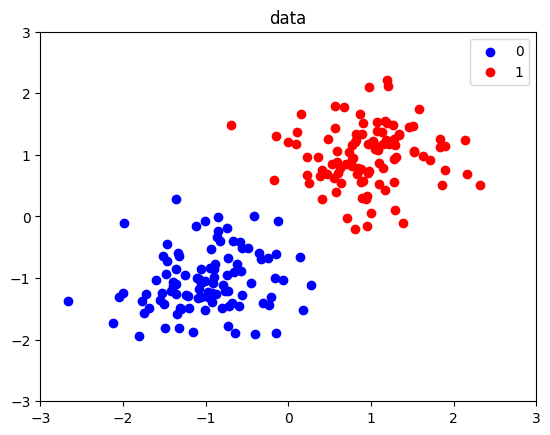

In [2]:
# Data to separate:
n = 100
std = 0.5

# Sample 1:
mean0 = torch.tensor((-1., -1.))
ech0 = mean0 + std * torch.randn(n, 2)

# Sample 2:
mean1 = torch.tensor((1., 1.))
ech1 = mean1 + std * torch.randn(n, 2)

echs = [ech0, ech1]

# Scatter plot:
fig, ax = plt.subplots()
ax.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r']
labels = ['0', '1']

for i, ech in enumerate(echs):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    ax.scatter(x, y, color=colors[i])

plt.legend(labels)

A simple perceptron (single neuron) consists of two parts: a linear part containing a dot product and a "bias" (b) and a non-linear part, the activation function (A):
\begin{equation*}
 f(x; \omega,b) = \mathcal{A}({\sum} \omega_i x_i  + b )  \tag{1}
\end{equation*}

The class P1 below codes for perceptrons defined on R^2 and whose activation function is a sigmoid:
\begin{equation*}
\mathcal{A}(y) = \dfrac{1}{1+e^{-y}}
\end{equation*}
The sigmoid function is in the range [0, 1]. Therefore, the neuron's output can be interpreted as the probability of belonging to the first of the two classes. In the P1 class, the neuron actually returns a vector of "probabilities":

In [3]:
class P1(nn.Module):

    def __init__(self):
        super(P1, self).__init__()
        self.fc = nn.Linear(2, 1)
        #a dense layer of 2 neurones

    def forward(self, x):
        # Dot product and bias
        x = self.fc(x)
        # Activation
        x = x.sigmoid()
        # Vector of "probabilities" (cat: concatenation)
        x = torch.cat((x, 1 - x), dim=1)
        return x

model = P1()
print(model)

P1(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


In the next cell, basic commands are given to access the weights of an instance of P1:

In [4]:
# Initialization (fantasy) of weights:
model.fc.weight[0, 0].data.fill_(-0.1)
model.fc.weight[0, 1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

# Retrieving weights:
fc = model.fc
weights = fc.weight.data.squeeze(dim=0)
bias = fc.bias.data

print(weights)
print(bias)

tensor([-0.1000,  0.5000])
tensor([-1.])


In [5]:
weights

tensor([-0.1000,  0.5000])

**Exercise 1**: Verify on an example that $f_c(x) = \sum \omega_i x_i  + b$

In [6]:
# YOUR CODE HERE
input = torch.tensor((-1.5, -8.))
result = fc(input)
act_res = np.dot(input,weights)+bias
result == act_res
#raise NotImplementedError()

tensor([True])

To complete the definition of the perceptron, a decision rule is needed. This rule is natural: for $f(x; \omega, b) = (p_0, p_1)$, we choose class 0 if $p_0 > p_1$.

We can plot the boundary that delimits the model's decision regions.

**Exercise 2:**
- Provide its equation in the form $x_1 = \alpha x_0 + \beta$ where $\alpha$ and $\beta$ depend on $\omega$ and $b$.
- Complete the code below to plot it:

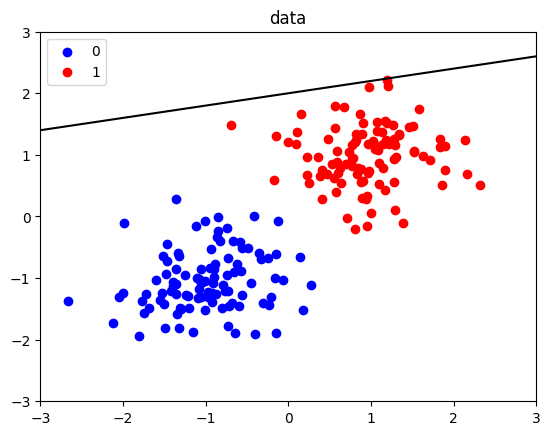

In [7]:
def traceFrontiere(weights, bias, ax, interval=[-10, 10], color='black'):
    x0 = np.arange(interval[0], interval[1], 0.01)
    x1 =(-weights[0]/weights[1])*x0+(-bias/weights[1])
    # YOUR CODE HERE
    ax.plot(x0, x1, color=color)

traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig

To train the perceptron to correctly separate the classes, we will use stochastic gradient descent with mini-batches. For this, we need to present the model with (*input*, *target*) pairs in a **random** order. In PyTorch, this selection is done using two objects:
- A *Dataset* class
- A *Dataloader* class

A PyTorch Dataset contains a method for accessing data. The following class provides a rudimentary example. Later on, we will integrate data loading, normalization, and data augmentation steps into our datasets:

In [8]:
from torch.utils.data import Dataset, DataLoader
class FirstDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):  # idx is an index called by the loader
        x = self.inputs[idx, :]
        t = self.targets[idx]
        return x, t  # (input, target) pair

inputs_train = torch.cat(echs, dim=0)
targets_train = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
ds1 = FirstDataset(inputs_train, targets_train)

A **loader** is a Python iterable (like lists, dictionaries, etc.) that we parameterize by batch size and data selection method (with or without replacement, weighting, etc). In particular, with the shuffle = True option, the data is reshuffled at every epoch and num_workers represents how many subprocesses to use for data loading, 0 means that the data will be loaded in the main process (generally interesting to anticipate data loading, to speed up training):

In [9]:
loader1 = DataLoader(ds1, batch_size=10, shuffle=True,num_workers=0)

In the following figure, we represent a first randomly drawn batch of points. Each time the window is executed, a new batch of points is drawn until exhaustion:

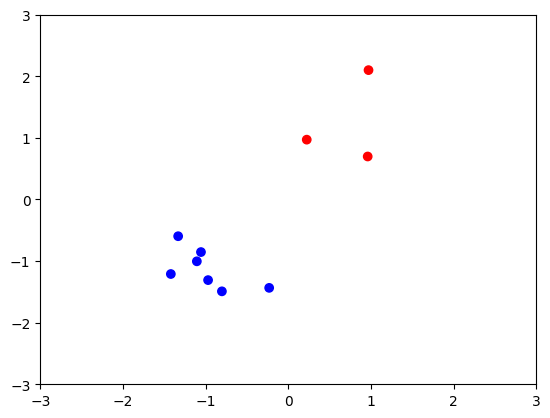

In [11]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.axis([-3, 3, -3, 3])

# Drawing a batch of ten points
inputs, targets = next(iter(loader1))
x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x, y, color=cs)

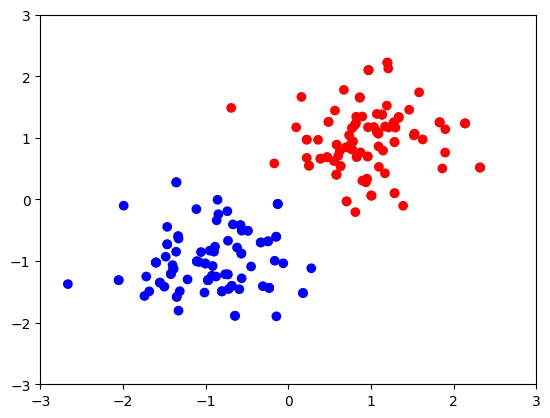

In [32]:
# Iterating over the dataset
inputs, targets = next(iter(loader1))
x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x, y, color=cs)
fig2

For each available batch, we calculate the model's error using a loss function. This loss function penalizes the differences between the network's outputs (here, pairs $(p_0, p_1)$) and the ground truth (here, a class $c \in \{ 0 ; 1 \}$).

In classification, we generally use the negative log likelihood. For a batch point, it is defined as:

$\mathcal{L}((p_0, p_1), c) = - ln(p_c)$

This quantity is averaged over each batch:

In [34]:
def loss_fn(outputs, targets, show=False):
    # all -log(p)
    outputs = -torch.log(outputs)
    # all -log(pc)
    tensor_of_losses = torch.gather(outputs, 1, targets.unsqueeze(dim=1))
    # average of -log(pc)
    loss = tensor_of_losses.mean()

    if show:
        print(outputs)
        print(targets)
        print(tensor_of_losses)

    return loss

Example:

In [35]:
inputs, targets = next(iter(loader1))
l = loss_fn(model(inputs), targets, show=True)

print(l)

tensor([[1.4007, 0.2829],
        [2.0692, 0.1350],
        [1.7298, 0.1952],
        [1.8295, 0.1749],
        [1.5098, 0.2497],
        [0.8739, 0.5401],
        [1.9747, 0.1494],
        [0.9021, 0.5204],
        [1.4558, 0.2655],
        [1.2068, 0.3555]], grad_fn=<NegBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0])
tensor([[1.4007],
        [2.0692],
        [1.7298],
        [1.8295],
        [1.5098],
        [0.5401],
        [1.9747],
        [0.5204],
        [0.2655],
        [1.2068]], grad_fn=<GatherBackward0>)
tensor(1.3047, grad_fn=<MeanBackward0>)


For each batch, we calculate the derivatives $\dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$ where $\mathcal{L_{batch}}$ is the average of the cost function over the batch.

PyTorch keeps track of each operation performed with the weights so that it can apply the usual rules of derivation. This calculation is launched with the *.backward* method. The derivatives are stored with the weights and can be accessed with *.grad*:

In [36]:
w = model.fc.weight  # [0,0]
print('before backward:' + str(w.grad))

l.backward()

print('after backward:' + str(w.grad))

before backward:None
after backward:tensor([[0.5638, 0.7504]])


Last step: updating the weights. For this, many methods are available. We specify the chosen method through the PyTorch "optimizer" object. The simplest is written:

$w_i := w_i - lr \times \dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$  (2)

The learning rate ($lr$) controls the amplitude of the increments:

In [37]:
lr = 0.1

# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # corresponds to equation (2)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In the next cell, we train the perceptron. With each new execution, the dataset is traversed twice (two "epochs"):

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


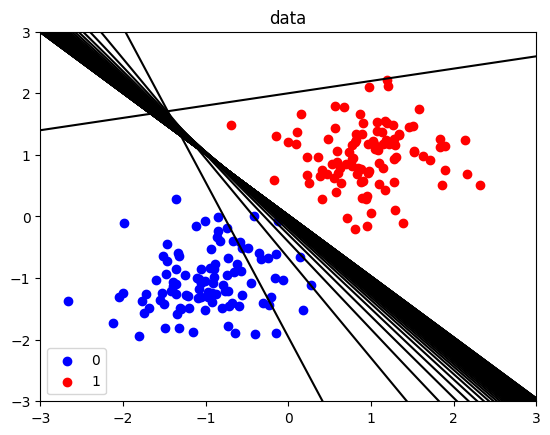

In [38]:
for epoch in range(100):
    print(epoch)
    # random traversal of the dataset
    for x, targets in loader1:
        # zeroing gradients
        optimizer.zero_grad()
        # calculation of (p0, p1)
        output = model(x)
        # calculation of the error
        l = loss_fn(output, targets)
        # calculation of gradients
        l.backward()
        # weight update
        optimizer.step()

    # Plotting the hyperplane
    fc = model.fc
    weights = fc.weight.data.squeeze(dim=0)
    bias = fc.bias.data
    traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig

**Exercise 3-1**: Complete the following code to plot the gradients in the $\omega_0, \omega_1$ weight space:

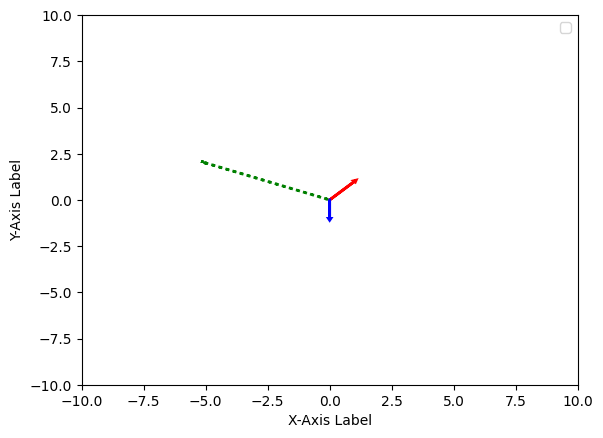

In [51]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.axis([-10, 10, -10, 10])

x_values = [1.0, 2.0, -1.5]
y_values = [2.0, -1.0, 0.5]

# # Plotting blue circles for data points
# ax3.scatter(x_values, y_values, c='b', marker='o', label='Class 0')

# # Assuming other_x_values and other_y_values are lists or arrays containing different coordinates
# other_x_values = [-2.0, 0.0, 1.5]
# other_y_values = [0.0, 1.5, -0.5]

# # Plotting green crosses for other data points
# ax3.scatter(other_x_values, other_y_values, c='g', marker='x', label='Class 1')
# Draw an arrow starting from (0, 0) and ending at (1, 1)
ax3.arrow(0, 0, 1, 1, color='red', linewidth=2, head_width=0.1, head_length=0.1)

# Draw another arrow starting from (2, -1) and ending at (-1, 2)
ax3.arrow(0, 0, 0, -1, color='blue', linewidth=2, head_width=0.1, head_length=0.1)

# Customize the appearance of the arrows using **kwargs
ax3.arrow(0, 0, -5, 2, color='green', linewidth=2, head_width=0.2, head_length=0.2, linestyle='dotted')


# Adding labels to the axes and legend
ax3.set_xlabel('X-Axis Label')
ax3.set_ylabel('Y-Axis Label')
ax3.legend()




tensor([-0.1000,  0.5000])


tensor([-0.1000,  0.5000])


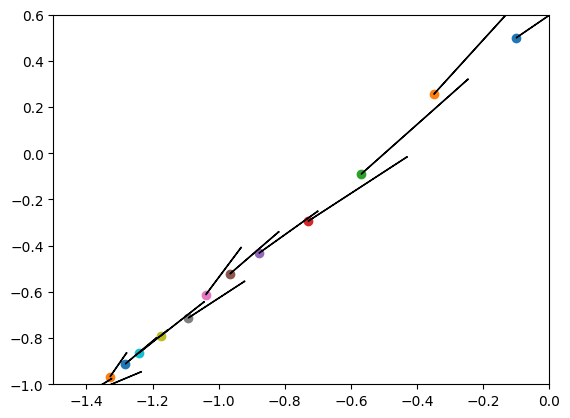

In [55]:
# Initialization of weights:
model.fc.weight[0, 0].data.fill_(-0.1)
model.fc.weight[0, 1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

print(model.fc.weight.data.squeeze(dim=0))
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.axis([-1.5, 0, -1, 0.6])

loader1 = DataLoader(ds1, batch_size=10, shuffle=True)
lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(25):
    for x, label in loader1:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()

        # plotting vectors:
        weights = model.fc.weight.data.squeeze(dim=0)
        # YOUR CODE HERE
        # raise NotImplementedError()

        ax3.scatter(weights[0],weights[1])
        ax3.arrow(weights[0],weights[1], model.fc.weight.grad[0,0], model.fc.weight.grad[0,1])
        # YOUR CODE HERE
        optimizer.step()

**Exercise 3-2:** Determine the accuracy of the classifier on the training set.

In [56]:
model.eval()


P1(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [65]:
for x, labels in loader1:
  print(x)
  print(label)
  print('*****************')

tensor([[-1.0555, -0.8536],
        [ 0.8225,  1.3429],
        [ 0.9714,  2.1000],
        [-1.4899, -1.8045],
        [ 1.1719,  1.1859],
        [ 2.1678,  0.6890],
        [ 0.4030,  0.7540],
        [-1.3485, -1.5804],
        [ 0.4872,  1.2606],
        [-0.6896,  1.4866]])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])
*****************
tensor([[-0.9491, -0.8300],
        [ 0.2513,  0.5488],
        [-1.3270, -0.6342],
        [ 0.8469,  0.7899],
        [ 1.1414,  1.1821],
        [-1.5242, -1.2354],
        [ 0.5249,  0.8452],
        [-1.4638, -0.4440],
        [ 0.9520,  0.3360],
        [-1.0930, -1.3223]])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])
*****************
tensor([[ 0.6336,  0.5416],
        [-0.7912, -1.1064],
        [-1.2178, -1.2981],
        [-0.8858, -0.7662],
        [ 1.5270,  1.0658],
        [-1.3546, -1.2631],
        [ 0.9613,  0.6979],
        [-0.7635, -1.2143],
        [-0.3571, -0.5916],
        [ 0.4102,  0.2788]])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])
****

In [63]:
vector = torch.tensor([[1,2,3,4,5,6]])
_, predicted = torch.max(vector, 1)
predicted

tensor([5])

In [58]:
correct_predictions = 0
total_samples = 0

for x, labels in loader1:
    # Forward pass
    with torch.no_grad():  # No need to track gradients during inference
        outputs = model(x)

    # Get the predicted labels (class with the maximum probability)
    _, predicted = torch.max(outputs, 1)

    # Update counts
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

# Calculate accuracy
accuracy = (correct_predictions / total_samples) * 100.0
print(f'Accuracy on the training set: {accuracy:.2f}%')

Accuracy on the training set: 100.00%


**Note:**

A model of the class *P1* corresponds to a class of statistical models widely used with predictors of small dimensions: logistic regression.

This model is used to **explain and predict** the value of a binary qualitative variable.

Let Z be a random variable with values in {c_1, c_2}.
Logistic regression with respect to the predictor $X = (X_1, X_2, ...)$ is written:

$$ ℙ(Z = c_1 | X ) = \sigma (\sum \omega_i X_i + b ) $$

Where $\sigma$ is the sigmoid function. In the context of logistic regression, the weights $\omega_i$ are obtained by **maximum likelihood**.

**B.** Now, let's consider the question of separating more complex sets of points:

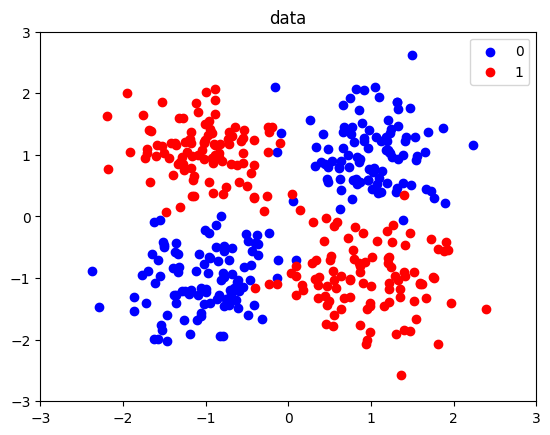

In [66]:
n = 100
std = 0.5
# sample 0:
meana = torch.tensor((-1., -1.))
echa = meana + std * torch.randn(n, 2)
meanb = torch.tensor((1., 1.))
echb = meanb + std * torch.randn(n, 2)

ech0 = torch.cat([echa, echb])

# sample :
meanc = torch.tensor((1., -1.))
echc = meanc + std * torch.randn(n, 2)
meand = torch.tensor((-1., 1.))
echd = meand + std * torch.randn(n, 2)

ech1 = torch.cat([echc, echd])

echs2 = [ech0, ech1]

# Scatter plot:

plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r']
labels = ['0', '1']

for i, ech in enumerate(echs2):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

**Exercise 4:**

What is the approximate best accuracy achievable with a model of class *P1*?

Complete the *P3* class and train a model to achieve an accuracy of at least 90% on the training set.

Why does the score after 50 epochs vary so much with each new training?

Is it possible, with another class of model, to achieve 100% accuracy?

In [67]:
class P3(nn.Module):

    def __init__(self):
        super(P3, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # first layer: 2 neurons
        self.fc2 = nn.Linear(2, 1)  # second layer: 1 neuron

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x.sigmoid()
        x = torch.cat((x, 1 - x), dim=1)  # output of sum 1
        return x

In [68]:
class FirstDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):  # idx is an index called by the loader
        x = self.inputs[idx, :]
        t = self.targets[idx]
        return x, t  # (input, target) pair

inputs_train = torch.cat(echs2, dim=0)
targets_train = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
ds2 = FirstDataset(inputs_train, targets_train)


loader2 = DataLoader(ds2, batch_size=10, shuffle=True,num_workers=0)

In [69]:
from tqdm import tqdm # Progess bar
lr = 0.1
model = P3()
# Two commonly used descent methods:
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(100)):
    for x, labels in loader2:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, targets)
        l.backward()
        optimizer.step()
print("\nTraining end")
# accuracy
correct = 0
total = 0
model.eval()

for x,labels in loader2:
  with torch.no_grad():
    outputs = model(x)
  _,predicted = torch.max(outputs,1)
  correct += (predicted==labels).sum().item()
  total += labels.size(0)

accuracy = (correct / total)*100.0

print(f'Accuracy on the training set: {accuracy:.2f}%')

100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Training end
Accuracy on the training set: 99.50%


In [70]:
class P9(nn.Module):

    def __init__(self):
        super(P9, self).__init__()
        self.fc1 = nn.Linear(2,4) # a first layer with 4 neurons
        self.fc2 = nn.Linear(4,4) # a second layer with 4 neurons
        self.fc3 = nn.Linear(4,1) # a third layer with 1 neuron
    def forward(self,x):
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x.sigmoid()
      x = torch.cat((x, 1 - x), dim=1)
      return x

In [72]:
model = P9()
from tqdm import tqdm # Progess bar
lr = 0.1
# Two commonly used descent methods:
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(1000)):
    for x, labels in loader2:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, targets)
        l.backward()
        optimizer.step()
print("\nTraining end")
# accuracy
correct = 0
total = 0
model.eval()

for x,labels in loader2:
  with torch.no_grad():
    outputs = model(x)
  _,predicted = torch.max(outputs,1)
  correct += (predicted==labels).sum().item()
  total += labels.size(0)

accuracy = (correct / total)*100.0

print(f'Accuracy on the training set: {accuracy:.2f}%')

100%|██████████| 1000/1000 [00:30<00:00, 33.23it/s]


Training end
Accuracy on the training set: 100.00%


As the complexity of the model increases, the boundaries can better adapt to the **training set**.

**C.** Now let's see how to generalize the approach to multiple classes:

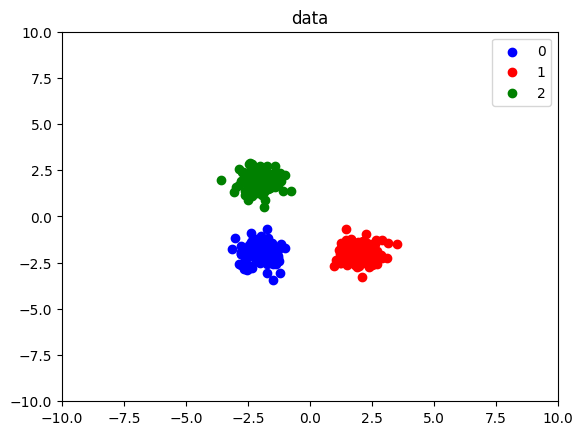

In [76]:
n = 100
std = 0.5
# Sample 0:
mean0 = torch.tensor((-2., -2.))
ech0 = mean0 + std * torch.randn(n, 2)

# Sample 1:
mean1 = torch.tensor((2., -2.))
ech1 = mean1 + std * torch.randn(n, 2)

# Sample 2:
mean2 = torch.tensor((-2., 2.))
ech2 = mean2 + std * torch.randn(n, 2)

echs3 = [ech0, ech1, ech2]

# Scatter plot:
plt.figure(0)
plt.axis([-10, 10, -10, 10])

plt.title('data')
colors = ['b', 'r', 'g']
labels = ['0', '1', '2']

for i, ech in enumerate(echs3):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

To separate these points, a two-layer perceptron should be sufficient. The problem is defining the cost function. To continue using the log-likelihood, the output layer will have as many neurons as classes. To define a probability distribution, normalized exponentials are used (softmax function):

$p_i = \dfrac{e^{y_i}}{\sum{e^{y_j}}}$
  
Where the $y_i$ are the outputs of the neurons in the last layer.

In [77]:
class P6(nn.Module):

    def __init__(self):
        super(P6, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # First layer: 2 neurons
        self.fc2 = nn.Linear(2, 3)  # Second layer: 3 neurons

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.softmax(dim=1)
        return x

**Exercise 5:** Create datasets and dataloaders objects and check if it is possible to separate the points (accuracy > 95%).

In [79]:
class FirstDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):  # idx is an index called by the loader
        x = self.inputs[idx, :]
        t = self.targets[idx]
        return x, t  # (input, target) pair

inputs3 = torch.cat(echs2, dim=0)
targets3 = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
ds3 = FirstDataset(inputs3, targets3)


loader3 = DataLoader(ds3, batch_size=10, shuffle=True,num_workers=0)
print(inputs3.shape)
print(targets3.shape)

torch.Size([400, 2])
torch.Size([200])


In [82]:
model = P6()
# YOUR CODE HERE
from tqdm import tqdm # Progess bar
lr = 0.1
# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(700)):
    for x, labels in loader3:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, targets)
        l.backward()
        optimizer.step()
print("\nTraining end")
# accuracy
correct = 0
total = 0
model.eval()

for x,labels in loader3:
  with torch.no_grad():
    outputs = model(x)
  _,predicted = torch.max(outputs,1)
  correct += (predicted==labels).sum().item()
  total += labels.size(0)

accuracy = (correct / total)*100.0

print(f'Accuracy on the training set: {accuracy:.2f}%')

100%|██████████| 700/700 [00:13<00:00, 52.76it/s]


Training end
Accuracy on the training set: 50.00%
